In [1]:
import time
import torch
import random

import numpy as np
import torch.nn as nn

from torchsummary import summary
from PIL import Image

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 "LGES_240621"로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES_240621

In [2]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 2024
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

#### 역전파 알고리즘 함수화하기

In [3]:
# 한 에폭에 대한 학습 단계 함수화
def train(model,
          optimizer,
          loss_fn,
          dataloader,
          device):
    
    model.train() # set train mode
    
    # epoch마다 학습이 어떻게 진행되는지 추적하기 위한 변수
    train_loss = 0.0
    train_acc = 0.0
    n_train = 0
    
    for (imgs, targets) in dataloader: # loader를 통해 batch만큼 getitem
        
         # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / n_train
    
    return train_loss, train_acc

In [4]:
 # 추론 단계 함수화
def test(model,
        loss_fn,
        dataloader,
        device):
    
    model.eval() # set eval mode
    
    test_loss = 0.0
    test_acc = 0.0
    n_test = 0
    
    with torch.no_grad():
        for (imgs, targets) in dataloader: # loader를 통해 batch만큼 getitem
            
            # 두 텐서를 모델, 목적함수와 같은 device로
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            # forward
            outputs = model(imgs) # B,2
            
            # loss 계산
            loss = loss_fn(outputs, targets)
            
            # loss 저장
            test_loss += loss.item()
            
            # 맞게 예측한 개수 및 배치 데이터 개수 저장
            preds = torch.max(outputs.detach(), dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            test_acc += acc
            n_test += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / n_test
    
    return test_loss, test_acc

In [5]:
# 전체적인 학습 프레임워크를 함수화
def main(model,
         trainloader,
         validloader,
         testloader,
         optimizer,
         loss_fn,
         epochs,
         save_name='cat_dog_lenet5'):
    
    # device 세팅
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        
    # To device
    model.to(device)
    loss_fn.to(device)
    
    # training
    best_acc = 0.
    train_history = {'loss':[],'acc':[]}
    valid_history = {'loss':[],'acc':[]}
    
    print('-'*20, '학습 시작', '-'*20)
    print(f'Experiment : {save_name} \n')
    
    elapsed_time = time.time()
    for epoch in range(epochs):
        epoch_time = time.time()
        # 한 에폭에 대한 학습
        train_loss, train_acc = train(model=model,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      dataloader=trainloader,
                                      device=device)
        # 에폭마다 validset을 통한 모델 평가
        valid_loss, valid_acc = test(model=model,
                                      loss_fn=loss_fn,
                                      dataloader=validloader,
                                      device=device)
        
        # best model일 경우 모델 저장
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_epoch = epoch+1
            save_dict = {'model':model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'epoch':best_epoch,
                        'acc':best_acc}
            torch.save(save_dict, f'./results/{save_name}.pt')
    
        # 학습/테스트에 소요된 시간 계산
        epoch_time = time.time() - epoch_time
        
        # 학습 정보 출력
        print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
        print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
        print(f'Train ACC : {train_acc:.4f} | Valid ACC : {valid_acc:.4f} \n')
    
        # 에폭별 학습 정보 저장
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        valid_history['loss'].append(valid_loss)
        valid_history['acc'].append(valid_acc)

    print('-'*20, '학습 종료', '-'*20)
    print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch} \n')
    
    print('-'*20, '테스트', '-'*20)
    # load best model
    load_dict = torch.load(f'./results/{save_name}.pt', map_location=device)
    parameters = load_dict['model'] 
    model.load_state_dict(parameters, strict=False)
    
    test_loss, test_acc = test(model=model,
                                loss_fn=loss_fn,
                                dataloader=testloader,
                                device=device)
    
    elapsed_time = time.time() - elapsed_time
    
    print(f'Experiments : {save_name}')
    print(f'test Loss   : {test_loss:.4f} \n')
    print(f'test ACC    : {test_acc:.4f} \n')
    print(f'Total Time  : {elapsed_time:.4f} \n')
    
    return train_history, valid_history

#### torchvision에서 제공하는 모델 가져오기

torchvision에서 제공하는 모델 : https://pytorch.org/vision/stable/models.html

VGG 모델 가져오기

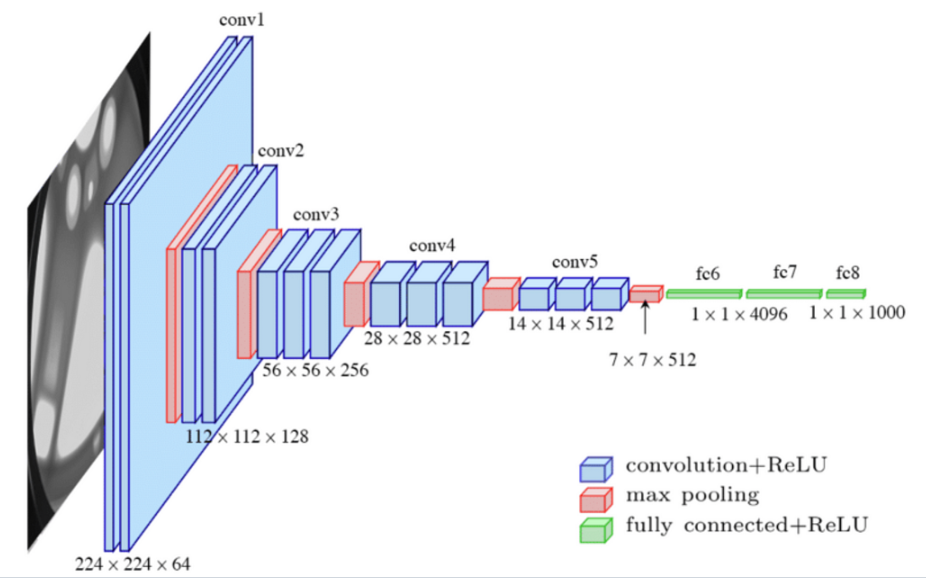

In [6]:
from torchvision.models import vgg16, VGG16_Weights

# DEFAULT : 해당 모델구조에서 torchvision에서 지원하는 사전학습 파라미터 중 가장 좋은 성능의 파라미터
model_vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

# None : 랜덤 초기화
# model_vgg16 = vgg16(weights=None)
summary(model_vgg16, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

#### VGG16 전이 학습하기

전이 학습(transfer learning) : 사전 학습 된 모델에서 classifier부분 혹은 마지막 출력층 파라미터만 현재 데이터에 맞게 재학습

미세 조정 학습(fine tunning) : 사전 학습 된 모델의 모든 파라미터를 현재 데이터에 맞게 세밀하게 조정하는 학습

In [7]:
# nn.Sequential은 딕셔너리처럼 key로 접근 가능
print(model_vgg16.classifier)
print(model_vgg16.classifier[6])

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Linear(in_features=4096, out_features=1000, bias=True)


In [8]:
# 파라미터가 업데이트 되지 않도록 모든 레이어에 대해 required_grad 끄기
for param in model_vgg16.parameters():
    param.requires_grad = False

In [9]:
# 마지막 출력층을 현재 데이터의 클래스 개수에 맞게 대체(required_grad는 자동으로 켜짐)
in_features = model_vgg16.classifier[-1].in_features
model_vgg16.classifier[-1] = nn.Linear(in_features,2)
print(model_vgg16.classifier[-1])
print(next(model_vgg16.classifier[-1].parameters()))

Linear(in_features=4096, out_features=2, bias=True)
Parameter containing:
tensor([[ 0.0032,  0.0056,  0.0141,  ..., -0.0014, -0.0046, -0.0087],
        [ 0.0104,  0.0155,  0.0136,  ..., -0.0152, -0.0084,  0.0014]],
       requires_grad=True)


#### 데이터셋 & 로더

In [10]:
# CatDogDataset
from PIL import Image
from glob import glob
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CatDogDataset(Dataset):
    def __init__(self, mode):
        # train 폴더 이미지 경로
        cat_train_path = glob(f'./data/dog_cat/train/cat/*') # train 폴더 cat 이미지 경로
        cat_train_labels = [0]*len(cat_train_path) # cat에 대한 레이블 생성

        dog_train_path = glob(f'./data/dog_cat/train/dog/*') # train 폴더 dog 이미지 경로
        dog_train_labels = [1]*len(dog_train_path) # dog에 대한 레이블 생성
        
        train_path = cat_train_path + dog_train_path
        train_labels = cat_train_labels + dog_train_labels
        
        # train/valid split
        train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels, test_size=0.3, random_state=2024)
        
        # test 폴더 이미지 경로
        cat_test_path = glob(f'./data/dog_cat/test/cat/*')
        cat_test_labels = [0]*len(cat_test_path)

        dog_test_path = glob(f'./data/dog_cat/test/dog/*')
        dog_test_labels = [1]*len(dog_test_path)
        
        # testset을 위한 cat 이미지 + dog 이미지
        test_path = dog_test_path + cat_test_path
        test_labels = dog_test_labels + cat_test_labels
        
        if mode == 'train':
            self.img_path = train_path
            self.labels = train_labels
            self.transform = tf.Compose([
                                      # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                      tf.RandAugment(num_ops=2, magnitude=9),
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor()
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                    ])
        elif mode == 'valid':
            self.img_path = valid_path
            self.labels = valid_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
        else:
            self.img_path = test_path
            self.labels = test_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
    
    def __len__(self):
          return len(self.img_path)
        
    def __getitem__(self,idx):
          crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
          img = Image.open(crt_img_path) # 이미지 오픈
          X = self.transform(img) # 이미지 변형
          
          y = self.labels[idx]
      
          return X, y

In [11]:
# 학습/테스트 데이터셋 및 데이터로더 생성
trainset = CatDogDataset(mode='train')

validset = CatDogDataset(mode='valid')

testset = CatDogDataset(mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=True)

validloader = DataLoader(dataset=validset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

print(f'trainset 이미지 수 : {len(trainset.img_path)}')
print(f'validset 이미지 수 : {len(validset.img_path)}')
print(f'testset 이미지 수  : {len(testset.img_path)}')

trainset 이미지 수 : 141
validset 이미지 수 : 61
testset 이미지 수  : 102


#### Optimizer & Loss_fn

In [12]:
learning_rate = 0.0003
optimizer = torch.optim.SGD(model_vgg16.classifier[-1].parameters(),
                           lr=learning_rate,
                           momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

#### 학습하는 함수를 호출해서 학습 시작

In [13]:
epochs = 50
train_history, valid_history = main(model=model_vgg16,
                                   trainloader=trainloader,
                                   validloader=validloader,
                                   testloader=testloader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=epochs,
                                   save_name='cat_dog_vgg16')

-------------------- 학습 시작 --------------------
Experiment : cat_dog_vgg16 

Epoch     :      1 | Time     : 4.55 sec
Train Loss: 1.0363 | Valid Loss: 0.6872
Train ACC : 0.3672 | Valid ACC : 0.5902 

Epoch     :      2 | Time     : 2.66 sec
Train Loss: 0.7224 | Valid Loss: 0.5763
Train ACC : 0.5156 | Valid ACC : 0.7049 

Epoch     :      3 | Time     : 3.01 sec
Train Loss: 0.6416 | Valid Loss: 0.4712
Train ACC : 0.6797 | Valid ACC : 0.8033 

Epoch     :      4 | Time     : 2.82 sec
Train Loss: 0.4919 | Valid Loss: 0.4014
Train ACC : 0.7578 | Valid ACC : 0.8525 

Epoch     :      5 | Time     : 2.92 sec
Train Loss: 0.3966 | Valid Loss: 0.3578
Train ACC : 0.8047 | Valid ACC : 0.8689 

Epoch     :      6 | Time     : 0.57 sec
Train Loss: 0.3675 | Valid Loss: 0.3295
Train ACC : 0.8750 | Valid ACC : 0.8689 

Epoch     :      7 | Time     : 0.53 sec
Train Loss: 0.2842 | Valid Loss: 0.3110
Train ACC : 0.8594 | Valid ACC : 0.8689 

Epoch     :      8 | Time     : 0.48 sec
Train Loss: 0.2745 | 

#### 학습 추세 시각화

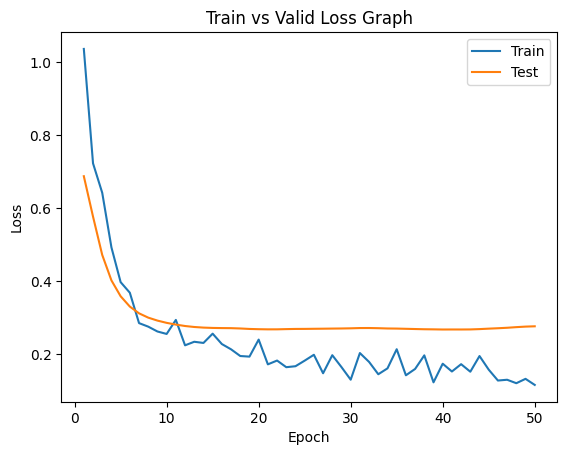

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1,epochs+1),y=train_history['loss'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['loss'], label='Test')
plt.title('Train vs Valid Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

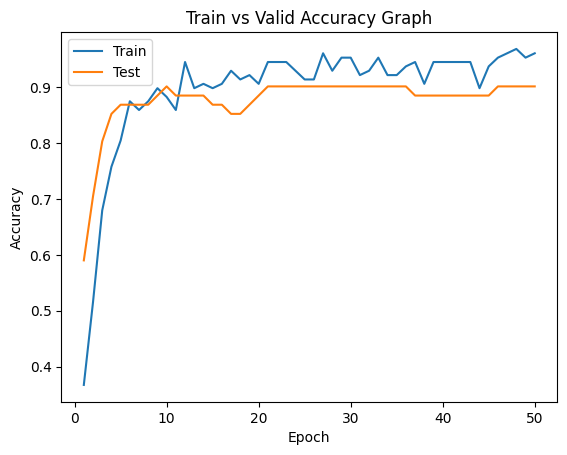

In [15]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['acc'], label='Test')
plt.title('Train vs Valid Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()